In [1]:
%%capture
!pip install aicrowd-cli

%load_ext aicrowd.magic

In [2]:
!python main_train.py --model_type fasterrcnn --config_path fasterrcnn.yaml

FasterRCNNConfig(
  datasets: <deepsense_vision.models.data_config.DataConfig object at 0x7f2c7748bd90>,
  name: 'Faster R-CNN',
  num_input_channels: 3,
  normalization_shift: [-0.485, -0.456, -0.406],
  normalization_scale: [4.367, 4.364, 4.444],
  anchor_sizes: [[32], [64], [128], [256], [512]],
  aspect_ratios: [[0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0]],
  classnames: ['N95', 'surgical', 'cloth', 'KN95'],
  pretrained_weights_COCO: True,
  pretrained_checkpoint_filepath: None,
  pretrained_weights_filepath: None,
  experiment_dirpath: 'experiments/20220210_132502_345197_faster_rcnn_training_1000',
  num_train_iters: 2000,
  verbose_freq_iters: 100,
  train_batch_size: 4,
  train_transformations: ['resize(512,512)', 'simple_augmentations(512, 512)'],
  init_lr: 0.0001,
  lr_step_size: 200,
  lr_gamma: 0.5,
  num_train_dataloader_workers: 0,
  class_balanced_sampling: False,
  multi_gpu: False,
  device: 'cuda',
  valid_freq_iters: 500,
  va

!rm -rf data
!mkdir data
%aicrowd ds dl -c mask-prediction -o data

!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

yolov3.yaml

datasets:
  train:
    metadata_path: train_metadata.json
    dataset_format: deepsense 
  valid:
    metadata_path: val_metadata.json
    dataset_format: deepsense 
classnames:
  - N95
  - surgical
  - cloth
  - KN95
input_height: 256
input_width: 256
experiment_dirpath: experiments/yolov3_training
num_train_iters: 2000 
valid_freq_iters: 200 
verbose_freq_iters: 100 
lr_step_size: 200
timestamped: True
train_transformations: ["resize(256,256)"]
valid_transformations: ["resize(256,256)"]


In [3]:
#Reading the file
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Image Reading & Preprocessing
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Misc.
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier

In [4]:
train_images = 'data/train'
val_images = 'data/val'
test_images = 'data/test'

In [5]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [6]:
train_df.head()

,ImageID,bbox,masktype
0,k8o0f,"[73, 197, 293, 400]",N95
1,7a0l9,"[47, 364, 300, 512]",surgical
2,wfp7p,"[203, 221, 380, 403]",N95
3,7qaw6,"[87, 210, 322, 385]",surgical
4,i4kqj,"[227, 283, 479, 475]",surgical


In [7]:
from ast import literal_eval

In [8]:
def create_bboxes(row):
    bbox_coords = literal_eval(row['bbox'])
    bbox = {"xmin": bbox_coords[0], "ymin": bbox_coords[1], "xmax": bbox_coords[2], "ymax": bbox_coords[3]}
    bbox['classname'] = row['masktype']
    bbox['probability'] = None
    return bbox

In [9]:
def create_item_metadata(image_path, row):
    item_metadata = {
        'image_path': str(Path(image_path) / (row['ImageID'] + ".jpg")),
        'namedboxes': [create_bboxes(row)],
        'namedmasks': [],
        'namedkeypoints': [],
        'image_classnames': []
    }
    return item_metadata

In [10]:
def create_dsvision_metadata(image_path, metadata_df):
    items = []
    for idx, row in metadata_df.iterrows():
        item_metadata = create_item_metadata(image_path, row) 
        items.append(item_metadata)
    return items

In [11]:
train_dsvision_metadata = create_dsvision_metadata(train_images, train_df)
val_dsvision_metadata = create_dsvision_metadata(val_images, val_df)

In [12]:
import json

In [13]:
json.dump(train_dsvision_metadata, open("train_metadata.json", "w"))
json.dump(val_dsvision_metadata, open("val_metadata.json", "w"))

In [14]:
for i in train_df['masktype'].unique():
    print("  - "+ i)

  - N95
  - surgical
  - cloth
  - KN95


In [15]:
import deepsense_vision

In [16]:

from deepsense_vision.datasets.deepsense_dataset import DeepsenseDataset
from deepsense_vision.io import load_json
from deepsense_vision.models.fasterrcnn.fasterrcnn_model import FasterRCNNModel
from deepsense_vision.models.yolov3.yolov3_model import YOLOv3Model 
from deepsense_vision.models.patchnet.patchnet_model import PatchNetModel

In [17]:
model = FasterRCNNModel()

In [18]:
!ls experiments/

20220205_223246_382917_yolov3_training
20220205_223330_776621_yolov3_training
20220205_223339_241858_yolov3_training
20220205_223533_778631_yolov3_training
20220205_223741_918155_faster_rcnn_training
20220205_224450_772442_faster_rcnn_training
20220210_095034_495233_faster_rcnn_training_1000
20220210_100434_304281_faster_rcnn_training_1000
20220210_100929_544292_faster_rcnn_training_1000
20220210_102822_739059_faster_rcnn_training_1000
20220210_123813_391604_faster_rcnn_training_1000
20220210_124238_344077_faster_rcnn_training_1000
20220210_131831_950098_faster_rcnn_training_1000
20220210_131900_003460_faster_rcnn_training_1000
20220210_132502_345197_faster_rcnn_training_1000


In [19]:
import pathlib


def load_results_from_config_path(experiment_path):
    results_path = pathlib.Path(experiment_path) / "checkpoint" / "valid_metrics.json"
    if os.path.exists(results_path):
        return json.load(open(str(results_path), "r"))['global']
    else:
        return None

In [20]:
!ls 20220210_124238_344077_faster_rcnn_training_1000/

ls: cannot access '20220210_124238_344077_faster_rcnn_training_1000/': No such file or directory


In [21]:
load_results_from_config_path("experiments/20220210_124238_344077_faster_rcnn_training_1000")

{'num_true_positives': 2393,
 'num_false_positives': 4,
 'num_false_negatives': 7,
 'precision': 0.9983312473925741,
 'recall': 0.9970833333333333,
 'f1': 0.9977069001459244,
 'mAP': 0.9248538594789876,
 'mAP@.50': 0.9925660609507732,
 'mAP@.75': 0.9925660609507732}

In [22]:
import glob

In [23]:
experiment_results_jsons = {
    config_path: load_results_from_config_path(config_path)
    for config_path in glob.glob("experiments/*")
}

In [24]:
experiment_results_jsons

{'experiments/20220210_132502_345197_faster_rcnn_training_1000': {'num_true_positives': 2390,
  'num_false_positives': 2,
  'num_false_negatives': 10,
  'precision': 0.9991638795986622,
  'recall': 0.9958333333333333,
  'f1': 0.9974958263772955,
  'mAP': 0.9280093848690896,
  'mAP@.50': 0.9925474773134191,
  'mAP@.75': 0.9925474773134191},
 'experiments/20220210_095034_495233_faster_rcnn_training_1000': {'num_true_positives': 2388,
  'num_false_positives': 6,
  'num_false_negatives': 12,
  'precision': 0.9974937343358395,
  'recall': 0.995,
  'f1': 0.9962453066332916,
  'mAP': 0.872780488748457,
  'mAP@.50': 0.9900864663452082,
  'mAP@.75': 0.9900864663452082},
 'experiments/20220205_223533_778631_yolov3_training': {'num_true_positives': 2270,
  'num_false_positives': 227,
  'num_false_negatives': 130,
  'precision': 0.9090909090909091,
  'recall': 0.9458333333333333,
  'f1': 0.9270982234020828,
  'mAP': 0.5916627182501502,
  'mAP@.50': 0.9338058821017383,
  'mAP@.75': 0.68052143931400

In [25]:
experiment_results = [
    {"experiment": path, **{k: v for (k,v) in results.items() if "mAP" in k}}
    for (path, results) in experiment_results_jsons.items()
    if not results is None
]

In [26]:
experiments_df = pd.DataFrame.from_records(experiment_results).sort_values("mAP", ascending=False)

In [27]:
experiments_df.index = experiments_df['experiment']

In [28]:
experiments_df

,experiment,mAP,mAP@.50,mAP@.75
experiment,,,,
experiments/20220205_224450_772442_faster_rcnn_training,experiments/20220205_224450_772442_faster_rcnn...,0.983145,0.990099,0.990099
experiments/20220210_100929_544292_faster_rcnn_training_1000,experiments/20220210_100929_544292_faster_rcnn...,0.936361,0.990099,0.990082
experiments/20220210_132502_345197_faster_rcnn_training_1000,experiments/20220210_132502_345197_faster_rcnn...,0.928009,0.992547,0.992547
experiments/20220210_124238_344077_faster_rcnn_training_1000,experiments/20220210_124238_344077_faster_rcnn...,0.924854,0.992566,0.992566
experiments/20220205_223741_918155_faster_rcnn_training,experiments/20220205_223741_918155_faster_rcnn...,0.916200,0.990023,0.989990
experiments/20220210_102822_739059_faster_rcnn_training_1000,experiments/20220210_102822_739059_faster_rcnn...,0.914580,0.992559,0.992559
experiments/20220210_095034_495233_faster_rcnn_training_1000,experiments/20220210_095034_495233_faster_rcnn...,0.872780,0.990086,0.990086
experiments/20220210_123813_391604_faster_rcnn_training_1000,experiments/20220210_123813_391604_faster_rcnn...,0.864627,0.992313,0.992309
experiments/20220205_223533_778631_yolov3_training,experiments/20220205_223533_778631_yolov3_trai...,0.591663,0.933806,0.680521


In [29]:
best_model_path = pathlib.Path(experiments_df['mAP'].idxmax()) / "checkpoint" / "fasterrcnn.pt"

In [30]:
model.load_checkpoint(str(best_model_path))

Loading from experiments/20220205_224450_772442_faster_rcnn_training/checkpoint/fasterrcnn.pt...
FasterRCNN loaded from experiments/20220205_224450_772442_faster_rcnn_training/checkpoint/fasterrcnn.pt successfully!


In [31]:
model.to_gpu()

In [32]:
from pathlib import Path

In [33]:
test_image_paths =  list(map(str, Path("data/test/").glob("*")))

In [34]:
import skimage.io
import skimage.transform

In [35]:
test_image_paths[0]

'data/test/3p1uk.jpg'

In [36]:
test_img = skimage.io.imread(test_image_paths[0])

In [37]:
test_img.shape

(512, 512, 3)

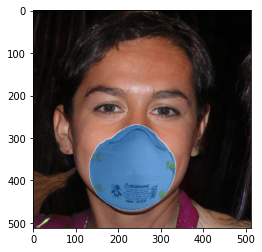

In [38]:
plt.imshow(test_img)

In [39]:
model.config.inference_preprocessing_longer_axis_size =  512 
model.config.inference_preprocessing_padding_min_image_height = 512 
model.config.inference_preprocessing_padding_min_image_width =  512 
model.config.inference_preprocessing_longer_axis_size = 512 
model.config.inference_sliding_window_height = 512 
model.config.inference_sliding_window_width = 512 

In [40]:
test_img.shape

(512, 512, 3)

In [41]:
test_img.transpose(-1, 0, 1).shape

(3, 512, 512)

In [42]:
pred = model.predict_from_array(test_img)

In [43]:
pred = model.predict_from_filepath(test_image_paths[1])

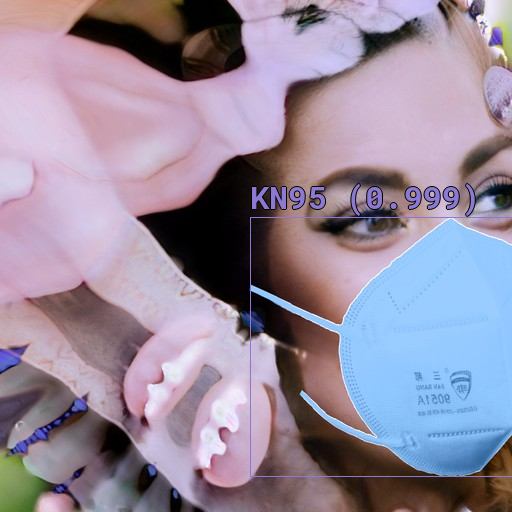

In [44]:
pred.visualize()

In [45]:
import tqdm
import numpy as np

In [46]:
def convert_box_coords_to_int(box):
    for key in ['xmin', 'xmax', 'ymin', 'ymax']:
        box[key] = int(np.round(box[key]))

In [47]:
raw_predictions = [
    [box.to_dict() for box in model.predict_from_filepath(str(p)).namedboxes]
    for p in tqdm.tqdm(test_image_paths)
]

100%|██████████| 2000/2000 [01:03<00:00, 31.42it/s]


In [48]:
for pred in raw_predictions:
    for b in pred:
        convert_box_coords_to_int(b)

In [49]:
raw_predictions[0]

[{'xmin': 129,
  'ymin': 270,
  'xmax': 335,
  'ymax': 471,
  'classname': 'N95',
  'probability': 0.9995693564414978}]

In [50]:
predictions = [b[0]  if len(b) > 0 else raw_predictions[0][0] for b in raw_predictions]

In [51]:
def box_to_str(box):
    return "[{}, {}, {}, {}]".format(box['xmin'], box['ymin'], box['xmax'], box['ymax'])

In [52]:
str_predictions = [box_to_str(b) for b in predictions]
cls_predictions = [b['classname'] for b in predictions]

In [53]:
idxs = [os.path.splitext(os.path.basename(p))[0] for p in test_image_paths]

In [54]:
preds_df = pd.DataFrame.from_records(zip(idxs, str_predictions, cls_predictions))

In [55]:
preds_df.columns = ['ImageID', 'bbox', 'masktype']

In [56]:
preds_df.to_csv('submission.csv', index=False)

In [ ]:
!cp Masks_DS_Vision.ipynb notebook.ipynb
!zip -r submission.zip notebook.ipynb submission.csv

In [58]:
!zip -r submission.zip submission/

updating: submission/ (stored 0%)
updating: submission/notebook.ipynb (deflated 42%)
updating: submission/submission.csv (deflated 63%)
updating: submission/submission.zip (stored 0%)


In [59]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/bloVZ-CQrDKUWNsk3I-7LFti9K_DtGovoPUXvppEL1E
API Key valid
Saved API Key successfully!


In [60]:
!aicrowd submission create -c mask-prediction -f submission.zip

submission.zip ━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 1.4/1.4 MB • 723.1 kB/s • 0:00:00 • 0:00:010:00:01
                                                  ╭─────────────────────────╮                                                   
                                                  │ Successfully submitted! │                                                   
                                                  ╰─────────────────────────╯                                                   
                                                        Important links                                                         
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions/173306              │
│                  │                                                                                                           │